First we prepare W-state with PennyLane.Notice this is with a fixed ansatz, with parameters optimized.

Second, we free those parameters and see if GradientDescent can find the optimals. It does.

In [196]:
import pennylane as qml
import gym
from pennylane import numpy as np
from gym import spaces
import matplotlib.pyplot as plt

In [172]:
ang=np.arccos(0.924) #obtained from Noise resiliance... Cerezo et.al.
np.sin(ang)
ang

0.3923841652634414

In [173]:
U1 = 1j*np.array([[np.cos(ang),np.sin(ang) ],[np.sin(ang), -np.cos(ang)]])
U1

array([[ 0.+0.924j     ,  0.+0.38239247j],
       [ 0.+0.38239247j, -0.-0.924j     ]])

In [234]:
np.arccos(0.924)*2

0.7847683305268828

In [174]:
dev = qml.device("default.qubit", analytic=True, wires=3)
@qml.qnode(dev)
def circuit(params):
    qml.RZ(np.pi, wires=[0])
    qml.PauliX(wires=[2])
    qml.RY(0.608*np.pi, wires=[1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[1,0])
    qml.RY(np.arccos(0.924)*2, wires=[0])
    qml.CNOT(wires=[1,0])
    qml.QubitUnitary(U1,wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.probs(wires=range(3))

In [175]:
print(circuit([]))
print("***")
print(circuit.draw())

[0.         0.33359023 0.33362461 0.         0.33278516 0.
 0.         0.        ]
***
 0: ──RZ(3.142)──────╭X──RY(0.785)──╭X──U0──╭C──╭┤ Probs 
 1: ──RY(1.91)───╭C──╰C─────────────╰C──────╰X──├┤ Probs 
 2: ──X──────────╰X─────────────────────────────╰┤ Probs 
U0 =
[[ 0.+0.924j       0.+0.38239247j]
 [ 0.+0.38239247j -0.-0.924j     ]]



In [176]:
sq = 1/np.sqrt(3)
w_state= np.array([0,sq,sq,0,sq,0,0,0])
def cost(output_circuit, target_state):
    return 1-np.dot(np.sqrt(output_circuit), target_state)

cost(circuit([]), w_state)

1.6931922264262766e-07

Now let's do the same but variatonally!

In [184]:
def projector(ket):
    n = len(ket)
    proj=np.zeros((n,n))
    for ind1,i in enumerate(ket):
        for ind2,j in enumerate(ket):
            proj[ind1,ind2] = i*np.conjugate(j)
    return proj
W = projector(w_state)

In [215]:
dev = qml.device("default.qubit", wires=3)
@qml.qnode(dev)
def circuit(params):
    qml.RZ(np.pi, wires=[0])
    qml.PauliX(wires=[2])
    qml.RY(params[0], wires=[1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[1,0])
    qml.RY(np.arccos(0.924)*2, wires=[0])
    qml.CNOT(wires=[1,0])
    qml.QubitUnitary(1j*np.array([[np.cos(0.39),np.sin(0.39) ],
                                  [np.sin(0.39), -np.cos(0.39)]])
,wires=[0])
    qml.CNOT(wires=[0,1])
    #return qml.probs(wires=range(3))
    return qml.expval(qml.Hermitian(W,wires=[0,1,2]))


In [207]:
dcircuit = qml.grad(circuit, argnum=0)

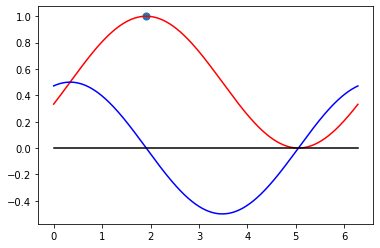

In [210]:
optimal = 0.608*np.pi
fids=[]
grad=[]
for k in np.arange(0,2*np.pi,.1):
    fids.append(circuit([k]))
    grad.append(dcircuit([k]))
plt.plot(np.arange(0,2*np.pi,.01), fids, c="red")
plt.plot(np.arange(0,2*np.pi,.01), grad, c="blue")
plt.scatter([optimal], [circuit([optimal])],s=50)
plt.plot([0, 2*np.pi], [0,0],c="black")

OK! Let's optimize this with gradient descent :)

In [218]:
def loss(x):
    return 1-circuit(x)

opt = qml.GradientDescentOptimizer(stepsize=0.1)

steps = 100
params = [np.random.random()]

for i in range(steps):
    params = opt.step(loss, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, loss(params)))
print("Optimized rotation angles: {}".format(params))
print("Optimal angle: {}".format(optimal))

Cost after step     5:  0.4542126
Cost after step    10:  0.3348710
Cost after step    15:  0.2329616
Cost after step    20:  0.1545380
Cost after step    25:  0.0989471
Cost after step    30:  0.0618196
Cost after step    35:  0.0380068
Cost after step    40:  0.0231300
Cost after step    45:  0.0139885
Cost after step    50:  0.0084284
Cost after step    55:  0.0050676
Cost after step    60:  0.0030438
Cost after step    65:  0.0018280
Cost after step    70:  0.0010985
Cost after step    75:  0.0006612
Cost after step    80:  0.0003992
Cost after step    85:  0.0002422
Cost after step    90:  0.0001482
Cost after step    95:  0.0000920
Cost after step   100:  0.0000582
Optimized rotation angles: [1.896447138509207]
Optimal angle: 1.9100883333825942


Nice! What happens if now I give you more free parameters ? (although there will be one point at which you'll see a barren plateau, i guess)

In [227]:
dev = qml.device("default.qubit", wires=3)
@qml.qnode(dev)
def circuit(params):
    qml.RZ(np.pi, wires=[0])
    qml.PauliX(wires=[2])
    qml.RY(params[0], wires=[1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[1,0])
    qml.RY(np.arccos(0.924)*2, wires=[0])
    qml.CNOT(wires=[1,0])
    qml.Rot(params[1],params[2],params[3],wires=[0])
    qml.CNOT(wires=[0,1])
    #return qml.probs(wires=range(3))
    return qml.expval(qml.Hermitian(W,wires=[0,1,2]))


In [229]:
print(circuit(np.pi*np.random.randn(4)))
print(circuit.draw())

0.06831318145984475
 0: ──RZ(3.142)──────╭X──RY(0.785)──╭X──Rot(2.086, 2.073, -1.422)──╭C──╭┤ ⟨H0⟩ 
 1: ──RY(5.389)──╭C──╰C─────────────╰C─────────────────────────────╰X──├┤ ⟨H0⟩ 
 2: ──X──────────╰X────────────────────────────────────────────────────╰┤ ⟨H0⟩ 
H0 =
[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.33333333 0.33333333 0.         0.33333333 0.
  0.         0.        ]
 [0.         0.33333333 0.33333333 0.         0.33333333 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.33333333 0.33333333 0.         0.33333333 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]



In [232]:
def loss(x):
    return 1-circuit(x)

opt = qml.GradientDescentOptimizer(stepsize=0.1)

steps = 500
params = np.pi*np.random.randn(4)

for i in range(steps):
    params = opt.step(loss, params)
    if (i + 1) % 10 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, loss(params)))

Cost after step    10:  0.9873988
Cost after step    20:  0.9852985
Cost after step    30:  0.9827180
Cost after step    40:  0.9794788
Cost after step    50:  0.9753228
Cost after step    60:  0.9698848
Cost after step    70:  0.9626657
Cost after step    80:  0.9530065
Cost after step    90:  0.9400652
Cost after step   100:  0.9227807
Cost after step   110:  0.8997824
Cost after step   120:  0.8691594
Cost after step   130:  0.8279620
Cost after step   140:  0.7713153
Cost after step   150:  0.6913570
Cost after step   160:  0.5778776
Cost after step   170:  0.4268719
Cost after step   180:  0.2607620
Cost after step   190:  0.1277322
Cost after step   200:  0.0523551
Cost after step   210:  0.0193752
Cost after step   220:  0.0068625
Cost after step   230:  0.0024070
Cost after step   240:  0.0008560
Cost after step   250:  0.0003172
Cost after step   260:  0.0001278
Cost after step   270:  0.0000593
Cost after step   280:  0.0000330
Cost after step   290:  0.0000218
Cost after ste

In [233]:
dev.shots

1000

In [236]:
params[1:]

array([-2.31419177e-03,  5.49757776e+00,  3.14314062e+00])

array([-2.31419177e-03,  5.49757776e+00,  3.14314062e+00])